In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU,Softmax
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 256
epochs = 100
batch_size = 28

In [3]:
train_data_path = 'vcm_data/train_data_one_im_norm_2set_256_vcm_discrinimator.npy'
#test_data_path = 'test_data.npy'
train_label_path = 'vcm_data/train_label_one_im_norm_2set_256_vcm_discrinimator.npy'
#test_label_path = 'test_label.npy'

In [4]:
data = np.load(train_data_path)
#test_data = np.load(test_data_path)
label = np.load(train_label_path)

In [5]:
print(data.shape)
print(label.shape)

(40000, 256, 256, 1)
(40000, 3)


In [6]:
train_data = data
train_label = label


In [7]:
#to_categorical(train_label[:, 2]).shape

In [8]:
# In[7]:
input_image1 = Input(shape=(256,256,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(4, (8, 8), 8,padding='same',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(8, (8, 8), 8,padding='same',activation=relu, name="Conv2_1")(layer1_1)

# layer3_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv3_1")(layer2_1)

# layer4_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv4_1")(layer3_1)

flattened = Flatten(name="flat")(layer2_1)
Dp1 = Dropout(0.5)(flattened)
dense1 = Dense(10, name="d1")(Dp1)
#ReLU1 = ReLU(name="lr1")(dense1)

output_position = Dense(1, activation='sigmoid', name="out")(dense1)

print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()


print(model.output_shape)

Tensor("out/Sigmoid:0", shape=(?, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 32, 32, 4)         260       
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 4, 4, 8)           2056      
_________________________________________________________________
flat (Flatten)               (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
d1 (Dense)                   (None, 10)                1290      
_________________________________________________________________
out (Dense)            

In [9]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)

model.fit(train_data, train_label[:, 2:], epochs = 20,batch_size = batch_size,validation_split=0.2, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 7s 224us/step - loss: 0.3600 - val_loss: 0.5860
Epoch 2/20
32000/32000 [==============================] - 5s 155us/step - loss: 0.3116 - val_loss: 0.2474
Epoch 3/20
32000/32000 [==============================] - 5s 159us/step - loss: 0.2496 - val_loss: 0.2980
Epoch 4/20
32000/32000 [==============================] - 6s 173us/step - loss: 0.3310 - val_loss: 0.5664
Epoch 5/20
32000/32000 [==============================] - 5s 164us/step - loss: 0.2921 - val_loss: 0.2574
Epoch 6/20
32000/32000 [==============================] - 5s 161us/step - loss: 0.2630 - val_loss: 0.2463
Epoch 7/20
32000/32000 [==============================] - 6s 178us/step - loss: 0.2507 - val_loss: 0.2492
Epoch 8/20
32000/32000 [==============================] - 6s 185us/step - loss: 0.2408 - val_loss: 0.2995
Epoch 9/20
32000/32000 [==============================] - 5s 165us/step - loss: 0.2202 - val_loss: 0.20

In [10]:
model.save('my_model_dis.h5')

model.save_weights('my_dis_weights.h5')

In [11]:
# print(to_categorical(train_label[:10, 2:]))

In [14]:
pred  = model.predict(train_data[:, :, :, :10])

[800. 975.   0.]
[0.02082265]


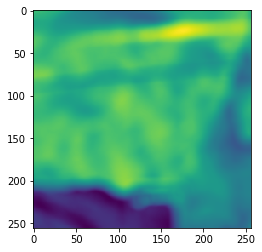

In [19]:
idx = 1
plt.imshow(train_data[idx, :, :, 0])

print(train_label[idx, :])
print(pred[idx, :])